## Problem 7.14

This problem is similar to 7.13, with an alteration to the initial conditions and the forcing. First, we note observe that there is no internal heating ($h=0$) -- is this a valid assumption for oceanic lithosphere? 

The domain boundary at $x=L$ is defined by the Neumann boundary condition that 
\begin{equation*}
\partial_x\theta(L,\,t) = 0 \quad. 
\end{equation*}
By analogy with Problem 7.13 this would be the left-hand-side boundary, i.e. the first element. The other boundary (the surface) is defined by the Dirichlet condition that 
\begin{equation*}
 \theta(0,\,t) = \theta_1 = 0 \quad. 
\end{equation*}

Considering the heat supply vector defined in Eqn 7.87, 
\begin{equation*}
F_A = - \,\theta_1 \int_0^1 \alpha\, \left( \,\partial_x N_A  \right)   \left( \partial_x N_{n+1} \right) \: \mathrm{d}x +  \int_0^1 \,N_A \, h\, \mathrm{d}x - \, N_A(0)\, \alpha(0) \, \partial_x \theta(0)
\end{equation*} we notice that the forcing term is always 0. 

#### Domain setup
Let us define the parameters for this simulation: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as ss

L       = 20        # Domain size
alpha   = 1         # Diffusivity

nelem   = 1000      # Elements
npts    = nelem + 1 # Control points

eta     = 0.5       # Time scheme param.
dt      = 0.05      # Time step

# Define grid points of domain
# and grid spacing 
# Note LHS is defined as L where
# Neumann condition exists
# and RHS (z=0) for Dirichlet BC
z = np.linspace(L, 0, npts)
dz =  z[:-1] - z[1:]

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Initial conditions
Note also that the Dirichlet boundary condition and initial condition are not compatible. It is sufficient to setup the problem with the initial condition being $\theta(x) = 1$ everywhere except $x=0$ where $\theta(x) = 0$, as plotted below.

Since the heat equation is a 1st order PDE in time, we do not need the initial condition for $\partial_t \theta(x,\, t=0)$. However, it is required by the time-marching scheme we are using. We can assume that it is 0. 

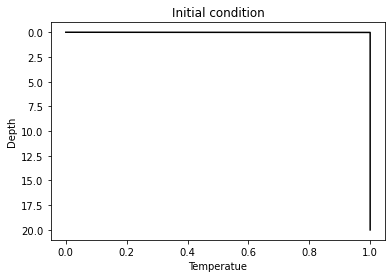

In [2]:
# Initial condition:
analytical = np.zeros(npts)
temp       = np.zeros(npts)

# assume initial dtemp/dt = 0
dtemp_dt = np.zeros(npts)

# zero only at surface
analytical[:-1] = 1
temp[:-1] = 1

# Plot initial condition 
fig, ax = plt.subplots()
ax.plot(analytical, z, 'k')
ax.set_ylim([21, -1]);
ax.set_title("Initial condition");
ax.set_ylabel("Depth");
ax.set_xlabel("Temperatue");

#### Capacity & Diffusivity matrices

The capacity and diffusivity matrices are identical to those in Problem 7.13. Let us build them once and time below

In [3]:
# Generate K & M matrices
M = np.zeros((nelem, nelem))
K = np.zeros((nelem, nelem))

for ielem in range(nelem):

    if ielem == 0:
        K[ielem, ielem] = 1 / dz[0]

        M[ielem, ielem] = dz[0] / 3
    else:
        K[ielem, ielem] = (1 / dz[ielem - 1]) + (1 / dz[ielem])
        K[ielem - 1, ielem] = -1 / dz[ielem - 1]
        K[ielem, ielem - 1] = -1 / dz[ielem - 1]

        M[ielem, ielem] = (dz[ielem - 1] + dz[ielem]) / 3
        M[ielem - 1, ielem] = dz[ielem - 1] / 6
        M[ielem, ielem - 1] = dz[ielem - 1] / 6

#### Time-marching

We can now time-march the system. To do this, we will use the predictor-corrector method in Eqns. 7.95 - 7.97. For 7.96, we need to compute
\begin{equation*}
\dot{\mathsf{d}}_{n+1} = \left( \mathsf{M} + \eta \Delta t \mathsf{K} \right)^{-1} \left[ - \mathsf{K}\, \tilde{\mathsf{d}}_{n+1} \right]
\end{equation*} 
since $\mathsf{F} = 0$. Note that this inverse matrix is not time dependent and so we may compute it only once. 

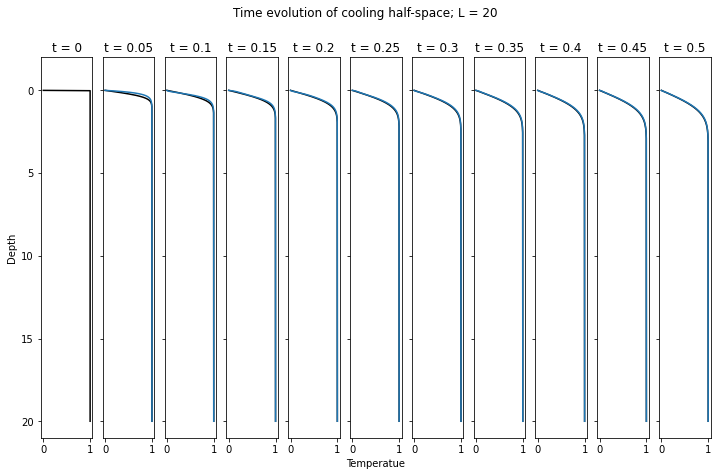

In [4]:
# Inverse of [M + eta \delta t K]
MKinv = np.linalg.inv(M + eta*dt*K)

# Create plots of time evolution
fig, ax = plt.subplots(1, 11, 
                       sharey=True, 
                       figsize=(12,7))


# Step in time 
time = 0

# Plot initial condition 
ax[0].plot(temp, z, 'k')

for istep in range(10):
    # Compute time 
    time += dt

    # Compute analytical solution
    argument = z / (2 * np.sqrt(alpha * time))
    analytical = ss.erf(argument)
    ax[1+istep].plot(analytical, z, 'k')

    # --- FEM calculation ---
    # Predictor:
    dtilde = temp[:-1] + (1-eta)* dt * dtemp_dt[:-1]

    # Solve for dtemp_dt at next timestep
    dtemp_dt[:-1] = np.matmul(MKinv,  - np.matmul(K, dtilde))

    # Corrector:
    temp[:-1] = dtilde + (eta * dt * dtemp_dt[:-1])

    ax[istep+1].set_title(f"t = {np.around(time,2)}");

    ax[istep+1].plot(temp, z)
    
    
# Some plot formatting 
ax[0].set_ylim([21, -0.1*L]);
ax[0].set_title(f"t = 0");
fig.suptitle(f"Time evolution of cooling half-space; L = {L}");
ax[0].set_ylabel("Depth");
ax[5].set_xlabel("Temperatue");

### Varying the domain size, L

When $L = 20$, we observe relatively good agreement between the analytical solution and FEM solution. How does this vary with L? In the hidden cell below, we re-run the entire code for $L = 1$ and $L=100$. We observe that the FEM simulation does a rather bad job at matching the analytical solution when $L=1$ but a good job for $L=100$. Why is this? 

The analytical solution is for a half-space, $x \in [0, \infty)$, but evidently our domain is finite. So now the question is how good is our finite domain at approximating the half-space? This depends on the properties of the medium. In particular, consider the characteristic length scale that is defined by the analytical solution,
\begin{align*}
\theta(x,\,t) = \text{erf}\left(\frac{x}{2\sqrt{\alpha \, t}} \right).  
\end{align*}

The length scale is then $\mathcal{L} \sim 2\sqrt{\alpha \, t}$. When this value is large, the error function tends to 0. When this value is small, the argument of the error function is large and theta tends towards 1. So we know that when $\mathcal{L} \sim 2\sqrt{\alpha \, t}$ is small, the temperature profile approximates the initial condition (where its 1 everywhere), while then the characteristic length scale is large, the temperature profile is essentially 0 everywhere.

This length scale essentially represents the length over which heat can diffuse within a given time. So when this value is large (relatively to the domain we have defined) the heat will diffuse out of it quickly. This is where we observe disagreement with the half-space solution, which is supposed to be infinitely large such that the heat does not diffuse out of the system. 

So, when our domain is too small (relative to the characteristic length scale defined by the time and the diffusivity, $\alpha$), our simulation does not replicate a half-space well. Note that with $\alpha = 1$ the characteristic length scale for $t = 0.5$ is 0.5. Hence, a domain of $L=1$ is not sufficiently large to represent infinite space.

Finally, note there are always some small differences for the first timestep(s) as the system adjusts from the inconsistent boundary and initial conditions. 

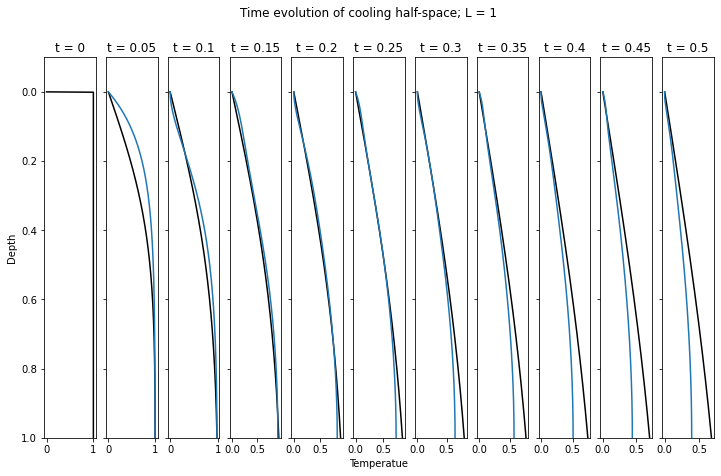

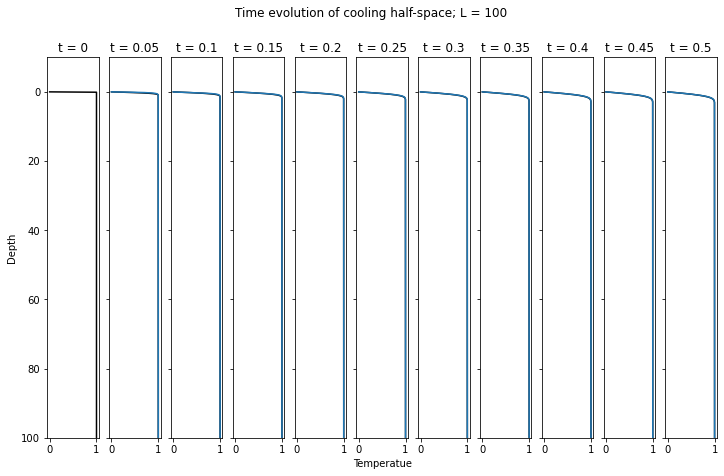

In [7]:
for L in [1, 100]: 
    # Grid points 
    z = np.linspace(L, 0, npts)
    dz =  z[:-1] - z[1:]

    # Initial condition:
    analytical = np.zeros(npts)
    temp       = np.zeros(npts)

    # assume initial dtemp/dt = 0
    dtemp_dt = np.zeros(npts)

    # zero only at surface
    analytical[:-1] = 1
    temp[:-1] = 1

    # Generate K & M matrices
    M = np.zeros((nelem, nelem))
    K = np.zeros((nelem, nelem))

    for ielem in range(nelem):

        if ielem == 0:
            K[ielem, ielem] = 1 / dz[0]
            M[ielem, ielem] = dz[0] / 3
        else:
            K[ielem, ielem] = (1 / dz[ielem - 1]) + (1 / dz[ielem])
            K[ielem - 1, ielem] = -1 / dz[ielem - 1]
            K[ielem, ielem - 1] = -1 / dz[ielem - 1]
            M[ielem, ielem] = (dz[ielem - 1] + dz[ielem]) / 3
            M[ielem - 1, ielem] = dz[ielem - 1] / 6
            M[ielem, ielem - 1] = dz[ielem - 1] / 6

    # Inverse of [M + eta \delta t K]
    MKinv = np.linalg.inv(M + eta*dt*K)
    # Create plots of time evolution
    fig, ax = plt.subplots(1, 11, 
                           sharey=True, 
                           figsize=(12,7))
    # Step in time 
    time = 0
    # Plot initial condition 
    ax[0].plot(temp, z, 'k')

    for istep in range(10):
        # Compute time 
        time += dt

        # Compute analytical solution
        argument = z / (2 * np.sqrt(alpha * time))
        analytical = ss.erf(argument)
        ax[1+istep].plot(analytical, z, 'k')

        # --- FEM calculation ---
        # Predictor:
        dtilde = temp[:-1] + (1-eta)* dt * dtemp_dt[:-1]
        # Solve for dtemp_dt at next timestep
        dtemp_dt[:-1] = np.matmul(MKinv,  - np.matmul(K, dtilde))
        # Corrector:
        temp[:-1] = dtilde + (eta * dt * dtemp_dt[:-1])
        ax[istep+1].set_title(f"t = {np.around(time,2)}");
        ax[istep+1].plot(temp, z)

    # Some plot formatting 
    ax[0].set_ylim([L, -0.1*L]);
    ax[0].set_title(f"t = 0");
    fig.suptitle(f"Time evolution of cooling half-space; L = {L}");
    ax[0].set_ylabel("Depth");
    ax[5].set_xlabel("Temperatue");